# DECO SCRIPT :
- Version : 13 / 04 / 2024 (13th April 2024)
- Author : Benoit Pierson
- Mail : benoitmarc.pierson@gmail.com

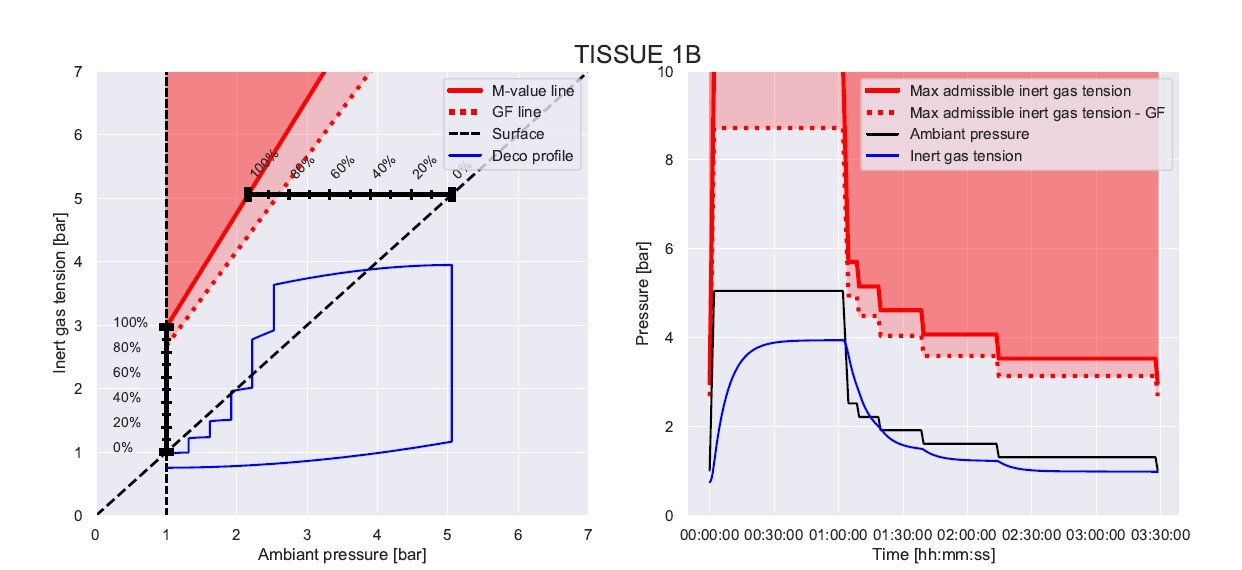

# SCOPE : 

- The aim of this work is to give an overview of the methodology used by a diving computer, not to replace it or to plan a dive !

- This is a non-certifies work. This work has not been checked properly (no peer review process) as it has to be for a real usage

- This notebook is useful if you want to visualize tissues saturations along time for a given dive (see at the end of this notebook)

# HYPOTHESIS : 
- We consider Buhlmann ZHL16-C model for M-values and half-times of 16 tissues
- We let the user choose the proper gradient factor he wants to use
- For the first tissue, we consider 1b
- Speed at descent is 20m/s
- Speed ascent is 10m/s to the first deco stop, 3m/s between deco stops, 3m/s to the surface (high considering common used values ~ 1m/s in last meters of ascent

In [1]:
from datetime import datetime, timedelta
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_theme()

# 1 - Definition of constants

In [2]:
rho_water = 1030.0 # Water density [kg/m**3]
p_water_vapor = 0.0627 # Water vapor pressure in lungs [bar]
p_atm_sea_level = 1.01325 # Ambiant pressure at sea level [bar]
g = 9.81 # gravity [m*s**-2]

In [3]:
def get_M_values(file_path):
    df_M_Values = pd.read_csv(file_path, sep = ";")
    M_values = {}
    for i in range(len(df_M_Values)):
        cell = df_M_Values.iloc[i]['Cell']
        HT = df_M_Values.iloc[i]['Half-time [sec]']
        M0 = df_M_Values.iloc[i]['M0']
        M_slope = df_M_Values.iloc[i]['M_slope']
        M_values[cell] = {}
        M_values[cell]["HT"] = HT
        M_values[cell]["M0"] = M0
        M_values[cell]["M_Slope"] = M_slope       
    return M_values



def define_dive_profile(depth, diving_time, desc_speed):
    descent_time = depth / desc_speed    
    start_time = datetime(1900, 1, 1, 0, 0, 0)
    bottom_arrival_time = start_time + timedelta(seconds = descent_time)
    end_time = bottom_arrival_time + timedelta(minutes = diving_time)
    df = pd.DataFrame({
        'Time' : [start_time, bottom_arrival_time, end_time],
        'Depth [m]'  : [0., depth, depth]})
    return df
    


def shreiner(k, R, P0, Pi0, t):
    # k : half-time constant = ln2/half-time [sec**-1]
    # R : rate of change in inspired gas pressure with change in ambient pressure [bar / sec]
    # Pi0 : initial inspired (alveolar) inert gas pressure [bar]
    # P0 : initial compartment inert gas pressure [bar]
    P = Pi0 + R * (t - (1/k)) - (Pi0 - P0 - (R/k)) * np.exp(-k*t)
    return P



def calculate_cell_saturation(df):
    nb_steps = len(df)
    time_steps = list(df["Time"])
    depth_steps = list(df["Depth [m]"])
    for cell in M_values.keys():
        HT = M_values[cell]['HT']
        k = np.log(2) / HT
        cell_saturation_along_times = list()
        for i in range(nb_steps):
            if (i == 0): 
                cell_saturation_along_times.append(0.79 * (p_atm_sea_level - p_water_vapor))
            else:
                P0 = cell_saturation_along_times[-1] # initial compartment inert gas pressure [bar]
                Pamb = p_atm_sea_level + (depth_steps[i-1] * rho_water * g) / 1E5
                Pi0 = N2Part * (Pamb - p_water_vapor) # initial inspired (alveolar) inert gas pressure [bar]
                depth_delta = depth_steps[i] - depth_steps[i-1]
                time_delta = (time_steps[i] - time_steps[i-1]).total_seconds()
                desc_speed = depth_delta / time_delta
                R = N2Part * desc_speed * ((rho_water * g) / 1E5) # R = rate of change in inspired gas pressure with change in ambient pressure [bar / sec]
                t = time_delta # time
                cell_saturation_along_times.append(shreiner(k, R, P0, Pi0, t))            
        df['pN2_cell_' + cell + ' [bar]'] = cell_saturation_along_times
    return df



def define_possible_deco_stops(df):
    possible_deco_stops = [*range(0, 1 + int(np.floor(df['Depth [m]'].max())), 3)]
    return possible_deco_stops


def pressure_at_depth(depth):
    return p_atm_sea_level + (rho_water * g * depth) / 1E5



def get_next_deco_stop(df, M_values, possible_deco_stops, GF_max_adm, ascent_speed):
    is_deco_stop_admissible = False
    for deco_stop_candidate in possible_deco_stops:
        is_deco_stop_admissible = True
        for cell in M_values.keys():         
            M0 = M_values[cell]['M0']
            M_slope = M_values[cell]['M_Slope']
            p_amb_stop_candidate = pressure_at_depth(deco_stop_candidate)
            M_value = M0 + M_slope * (p_amb_stop_candidate - p_atm_sea_level)
            max_adm_inert_gas_pressure = (1 - GF_max_adm) * p_amb_stop_candidate + GF_max_adm * M_value
            p_inert_gas_candidate = calculate_cell_saturation_after_ascent(df, cell, deco_stop_candidate, ascent_speed)
            if (p_inert_gas_candidate > max_adm_inert_gas_pressure):
                is_deco_stop_admissible = False 
        if (is_deco_stop_admissible):
            break
    return deco_stop_candidate

            
def calculate_cell_saturation_after_ascent(df, cell, depth_stop, ascent_speed):
    depth_current = df['Depth [m]'].values[-1]
    HT = M_values[cell]['HT']
    k = np.log(2) / HT
    P0 = df['pN2_cell_' + str(cell) + ' [bar]'].values[-1]
    Pamb = p_atm_sea_level + (depth_current * rho_water * g) / 1E5
    Pi0 = N2Part * (Pamb - p_water_vapor)
    R = - N2Part * ascent_speed * ((rho_water * g) / 1E5)
    t = np.abs(depth_current - depth_stop) / ascent_speed
    return shreiner(k, R, P0, Pi0, t)



def interpolate_max_GF_at_depth(depth, first_deco_depth, GF_low, GF_high):
    return GF_high - ((GF_high - GF_low) * depth / first_deco_depth)


def calculate_cell_GF(cell, depth, inert_gas_tension):
    M0 = M_values[cell]['M0']
    M_slope = M_values[cell]['M_Slope']
    ambiant_pressure = pressure_at_depth(depth)
    M_value = M0 + M_slope * (ambiant_pressure - p_atm_sea_level)
    return max(0, (inert_gas_tension - ambiant_pressure) / (M_value - ambiant_pressure))


def calculate_ascent_profile(df):
    ascent_beginning = True
    
    while (df['Depth [m]'].values[-1] != 0):
    
        if (ascent_beginning):
            first_deco_stop = get_next_deco_stop(df, M_values, possible_deco_stops, GF_low, ascent_speed)
            depth = first_deco_stop
            ascent_duration = np.abs(first_deco_stop - df['Depth [m]'].values[-1]) / ascent_speed
            time = df['Time'].values[-1] + np.timedelta64(int(np.ceil(ascent_duration)), 's')
            df = df.append({'Time' : time, 'Depth [m]' : depth}, ignore_index = True)
            df = calculate_cell_saturation(df)
            ascent_beginning = False
        
        else:
            depth = df['Depth [m]'].values[-1]
            GF_max = interpolate_max_GF_at_depth(depth, first_deco_stop, GF_low, GF_high)
            next_depth = get_next_deco_stop(df, M_values, possible_deco_stops, GF_max, ascent_speed_between_stops)
        
            if (depth == next_depth):
                time = df['Time'].values[-1] + np.timedelta64(60, 's')
                df = df.append({'Time' : time, 'Depth [m]' : depth}, ignore_index = True)
                df = calculate_cell_saturation(df)
            
            else:
                ascent_duration = 3 / ascent_speed_between_stops
                time = df['Time'].values[-1] + np.timedelta64(int(np.ceil(ascent_duration)), 's')
                df = df.append({'Time' : time, 'Depth [m]' : depth - 3}, ignore_index = True)
                df = calculate_cell_saturation(df)
    
    df_g = df.iloc[1:].groupby(['Depth [m]']).agg({'Time' : ['min', 'max']}).reset_index(drop = False)
    df_g.columns = ['Depth [m]', 'Time - min', 'Time - max']
    df_g['Duration at depth'] = ((df_g['Time - max'] - df_g['Time - min']).dt.total_seconds() / 60).astype('int')
    df_g = df_g.sort_values(by = "Time - min").reset_index(drop = True)
    df_g['Ascent duration'] = 0.
    for i in range(1, len(df_g)):
        df_g['Ascent duration'].iloc[i] = np.ceil((df_g['Time - min'].iloc[i] - df_g['Time - max'].iloc[i-1]).total_seconds() / 60)
    df_g['Ascent duration'] = df_g['Ascent duration'].astype('int')
    df_g['Time - min'] = df_g['Time - min'].dt.time
    df_g['Time - max'] = df_g['Time - max'].dt.time
    df_g = df_g[['Depth [m]', 'Time - min', 'Time - max', 'Ascent duration', 'Duration at depth']]
    
    return df, df_g, first_deco_stop


In [4]:
GF_low = 0.9
GF_high = 0.9
N2Part = 0.79
descent_speed = 20 / 60
ascent_speed = 10 / 60
ascent_speed_between_stops = 3 / 60

M_values = get_M_values("Buhlmann_Zh-L16C_M-values.csv")
df = define_dive_profile(depth = 60, diving_time = 30, desc_speed = descent_speed)
df = calculate_cell_saturation(df)
possible_deco_stops = define_possible_deco_stops(df)
df, deco_planner, first_deco_stop = calculate_ascent_profile(df)               

C:\Users\benoi\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
print(deco_planner)

   Depth [m] Time - min Time - max  Ascent duration  Duration at depth
0       60.0   00:03:00   00:33:00                0                 30
1       18.0   00:37:12   00:40:12                5                  3
2       15.0   00:41:12   00:46:12                1                  5
3       12.0   00:47:12   00:54:12                1                  7
4        9.0   00:55:12   01:10:12                1                 15
5        6.0   01:11:12   01:38:12                1                 27
6        3.0   01:39:12   02:31:12                1                 52
7        0.0   02:32:12   02:32:12                1                  0


In [6]:
start = df['Time'].min()
end = df['Time'].max()
nb_secs = int((df['Time'].max() - df['Time'].min()).total_seconds()) + 1
times = [start + np.timedelta64(i, 's') for i in range(nb_secs)]
df2 = pd.DataFrame({'Time' : times})
df2 = pd.merge(left = df2, right = df[['Time', 'Depth [m]']], left_on = ['Time'], right_on = ['Time'], how = 'left')
df2['Depth [m]'] = df2['Depth [m]'].interpolate(method = 'linear')
df2['Ambiant Pressure [bar]'] = df2['Depth [m]'].apply(lambda x : p_atm_sea_level + (rho_water * g * x) / 1E5)
df2 = calculate_cell_saturation(df2)   

In [7]:
df2

,Time,Depth [m],Ambiant Pressure [bar],pN2_cell_1b [bar],pN2_cell_2 [bar],pN2_cell_3 [bar],pN2_cell_4 [bar],pN2_cell_5 [bar],pN2_cell_6 [bar],pN2_cell_7 [bar],pN2_cell_8 [bar],pN2_cell_9 [bar],pN2_cell_10 [bar],pN2_cell_11 [bar],pN2_cell_12 [bar],pN2_cell_13 [bar],pN2_cell_14 [bar],pN2_cell_15 [bar],pN2_cell_16 [bar]
0,1900-01-01 00:00:00,0.000000,1.013250,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935
1,1900-01-01 00:00:01,0.333333,1.046931,0.750965,0.750954,0.750947,0.750943,0.750940,0.750939,0.750937,0.750936,0.750936,0.750936,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935
2,1900-01-01 00:00:02,0.666667,1.080612,0.751057,0.751011,0.750984,0.750968,0.750957,0.750951,0.750946,0.750942,0.750940,0.750939,0.750938,0.750937,0.750937,0.750936,0.750936,0.750935
3,1900-01-01 00:00:03,1.000000,1.114293,0.751211,0.751107,0.751045,0.751009,0.750986,0.750971,0.750960,0.750952,0.750947,0.750944,0.750942,0.750940,0.750939,0.750938,0.750937,0.750937
4,1900-01-01 00:00:04,1.333333,1.147974,0.751425,0.751241,0.751131,0.751067,0.751026,0.750999,0.750980,0.750966,0.750957,0.750951,0.750948,0.750945,0.750943,0.750941,0.750939,0.750938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9128,1900-01-01 02:32:08,0.200000,1.033459,0.976700,0.984368,1.005955,1.069600,1.193455,1.332590,1.436448,1.467601,1.427305,1.356288,1.283206,1.207966,1.136127,1.070096,1.012423,0.963372
9129,1900-01-01 02:32:09,0.150000,1.028406,0.976211,0.984051,1.005733,1.069410,1.193272,1.332418,1.436305,1.467496,1.427235,1.356241,1.283174,1.207944,1.136113,1.070087,1.012418,0.963368
9130,1900-01-01 02:32:10,0.100000,1.023354,0.975714,0.983729,1.005507,1.069217,1.193087,1.332246,1.436162,1.467390,1.427164,1.356194,1.283142,1.207923,1.136098,1.070077,1.012412,0.963365
9131,1900-01-01 02:32:11,0.050000,1.018302,0.975209,0.983402,1.005277,1.069022,1.192900,1.332073,1.436017,1.467283,1.427093,1.356146,1.283110,1.207901,1.136084,1.070068,1.012406,0.963361


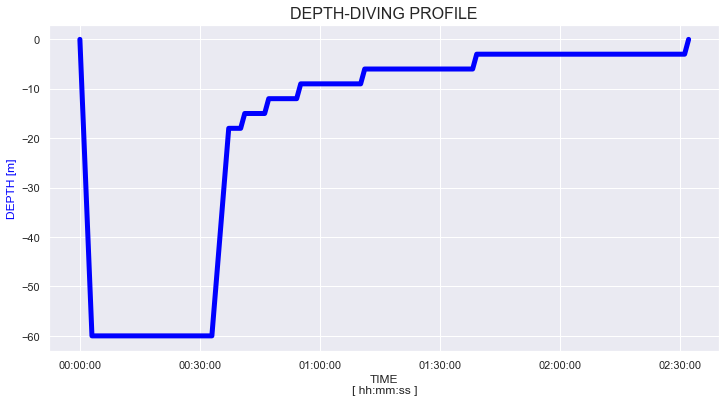

In [8]:
fig, ax = plt.subplots(1, figsize = (12, 6))
#ax2 = ax.twinx() 
ax.plot(df2['Time'], -df2['Depth [m]'], linewidth = 5, c = "blue")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_xlabel('TIME\n[ hh:mm:ss ]', fontsize = 12)
ax.set_ylabel('DEPTH [m]', fontsize = 12, color = "blue")
#ax2.plot(df2['Time'], df2['Ambiant Pressure [bar]'], linewidth = 1, c = "red")
#ax2.set_ylabel('Ambiant Pressure [bar]', fontsize = 12, color = 'red')
plt.title('DEPTH-DIVING PROFILE', fontsize = 16)
plt.show()

In [9]:
df2

,Time,Depth [m],Ambiant Pressure [bar],pN2_cell_1b [bar],pN2_cell_2 [bar],pN2_cell_3 [bar],pN2_cell_4 [bar],pN2_cell_5 [bar],pN2_cell_6 [bar],pN2_cell_7 [bar],pN2_cell_8 [bar],pN2_cell_9 [bar],pN2_cell_10 [bar],pN2_cell_11 [bar],pN2_cell_12 [bar],pN2_cell_13 [bar],pN2_cell_14 [bar],pN2_cell_15 [bar],pN2_cell_16 [bar]
0,1900-01-01 00:00:00,0.000000,1.013250,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935
1,1900-01-01 00:00:01,0.333333,1.046931,0.750965,0.750954,0.750947,0.750943,0.750940,0.750939,0.750937,0.750936,0.750936,0.750936,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935
2,1900-01-01 00:00:02,0.666667,1.080612,0.751057,0.751011,0.750984,0.750968,0.750957,0.750951,0.750946,0.750942,0.750940,0.750939,0.750938,0.750937,0.750937,0.750936,0.750936,0.750935
3,1900-01-01 00:00:03,1.000000,1.114293,0.751211,0.751107,0.751045,0.751009,0.750986,0.750971,0.750960,0.750952,0.750947,0.750944,0.750942,0.750940,0.750939,0.750938,0.750937,0.750937
4,1900-01-01 00:00:04,1.333333,1.147974,0.751425,0.751241,0.751131,0.751067,0.751026,0.750999,0.750980,0.750966,0.750957,0.750951,0.750948,0.750945,0.750943,0.750941,0.750939,0.750938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9128,1900-01-01 02:32:08,0.200000,1.033459,0.976700,0.984368,1.005955,1.069600,1.193455,1.332590,1.436448,1.467601,1.427305,1.356288,1.283206,1.207966,1.136127,1.070096,1.012423,0.963372
9129,1900-01-01 02:32:09,0.150000,1.028406,0.976211,0.984051,1.005733,1.069410,1.193272,1.332418,1.436305,1.467496,1.427235,1.356241,1.283174,1.207944,1.136113,1.070087,1.012418,0.963368
9130,1900-01-01 02:32:10,0.100000,1.023354,0.975714,0.983729,1.005507,1.069217,1.193087,1.332246,1.436162,1.467390,1.427164,1.356194,1.283142,1.207923,1.136098,1.070077,1.012412,0.963365
9131,1900-01-01 02:32:11,0.050000,1.018302,0.975209,0.983402,1.005277,1.069022,1.192900,1.332073,1.436017,1.467283,1.427093,1.356146,1.283110,1.207901,1.136084,1.070068,1.012406,0.963361


In [10]:
cells = list(M_values.keys())

for cell in cells:
    col_name = "pN2_cell_" + cell + " [bar]"
    M0 = M_values[cell]['M0']
    M_slope = M_values[cell]['M_Slope']
    df2["GF_" + cell] = df2.apply(lambda x: max(0, (x[col_name] - x['Ambiant Pressure [bar]']) / (M0 + M_slope * (x['Ambiant Pressure [bar]'] - p_atm_sea_level) - x['Ambiant Pressure [bar]'])), axis = 1)
        

In [11]:
df2

,Time,Depth [m],Ambiant Pressure [bar],pN2_cell_1b [bar],pN2_cell_2 [bar],pN2_cell_3 [bar],pN2_cell_4 [bar],pN2_cell_5 [bar],pN2_cell_6 [bar],pN2_cell_7 [bar],...,GF_7,GF_8,GF_9,GF_10,GF_11,GF_12,GF_13,GF_14,GF_15,GF_16
0,1900-01-01 00:00:00,0.000000,1.013250,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1,1900-01-01 00:00:01,0.333333,1.046931,0.750965,0.750954,0.750947,0.750943,0.750940,0.750939,0.750937,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
2,1900-01-01 00:00:02,0.666667,1.080612,0.751057,0.751011,0.750984,0.750968,0.750957,0.750951,0.750946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
3,1900-01-01 00:00:03,1.000000,1.114293,0.751211,0.751107,0.751045,0.751009,0.750986,0.750971,0.750960,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
4,1900-01-01 00:00:04,1.333333,1.147974,0.751425,0.751241,0.751131,0.751067,0.751026,0.750999,0.750980,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9128,1900-01-01 02:32:08,0.200000,1.033459,0.976700,0.984368,1.005955,1.069600,1.193455,1.332590,1.436448,...,0.693447,0.848670,0.849473,0.763517,0.639063,0.487418,0.314401,0.123568,0,0
9129,1900-01-01 02:32:09,0.150000,1.028406,0.976211,0.984051,1.005733,1.069410,1.193272,1.332418,1.436305,...,0.702814,0.859378,0.861156,0.776138,0.652525,0.501919,0.330111,0.140691,0,0
9130,1900-01-01 02:32:10,0.100000,1.023354,0.975714,0.983729,1.005507,1.069217,1.193087,1.332246,1.436162,...,0.712203,0.870111,0.872863,0.788783,0.666012,0.516445,0.345847,0.157843,0,0
9131,1900-01-01 02:32:11,0.050000,1.018302,0.975209,0.983402,1.005277,1.069022,1.192900,1.332073,1.436017,...,0.721616,0.880869,0.884594,0.801453,0.679524,0.530998,0.361610,0.175021,0,0


In [12]:
df2[["GF_1b"] + ["GF_" + str(i) for i in range(2, 17)]].max().max()

0.8963510129560388

In [13]:
df2

,Time,Depth [m],Ambiant Pressure [bar],pN2_cell_1b [bar],pN2_cell_2 [bar],pN2_cell_3 [bar],pN2_cell_4 [bar],pN2_cell_5 [bar],pN2_cell_6 [bar],pN2_cell_7 [bar],...,GF_7,GF_8,GF_9,GF_10,GF_11,GF_12,GF_13,GF_14,GF_15,GF_16
0,1900-01-01 00:00:00,0.000000,1.013250,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,0.750935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1,1900-01-01 00:00:01,0.333333,1.046931,0.750965,0.750954,0.750947,0.750943,0.750940,0.750939,0.750937,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
2,1900-01-01 00:00:02,0.666667,1.080612,0.751057,0.751011,0.750984,0.750968,0.750957,0.750951,0.750946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
3,1900-01-01 00:00:03,1.000000,1.114293,0.751211,0.751107,0.751045,0.751009,0.750986,0.750971,0.750960,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
4,1900-01-01 00:00:04,1.333333,1.147974,0.751425,0.751241,0.751131,0.751067,0.751026,0.750999,0.750980,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9128,1900-01-01 02:32:08,0.200000,1.033459,0.976700,0.984368,1.005955,1.069600,1.193455,1.332590,1.436448,...,0.693447,0.848670,0.849473,0.763517,0.639063,0.487418,0.314401,0.123568,0,0
9129,1900-01-01 02:32:09,0.150000,1.028406,0.976211,0.984051,1.005733,1.069410,1.193272,1.332418,1.436305,...,0.702814,0.859378,0.861156,0.776138,0.652525,0.501919,0.330111,0.140691,0,0
9130,1900-01-01 02:32:10,0.100000,1.023354,0.975714,0.983729,1.005507,1.069217,1.193087,1.332246,1.436162,...,0.712203,0.870111,0.872863,0.788783,0.666012,0.516445,0.345847,0.157843,0,0
9131,1900-01-01 02:32:11,0.050000,1.018302,0.975209,0.983402,1.005277,1.069022,1.192900,1.332073,1.436017,...,0.721616,0.880869,0.884594,0.801453,0.679524,0.530998,0.361610,0.175021,0,0


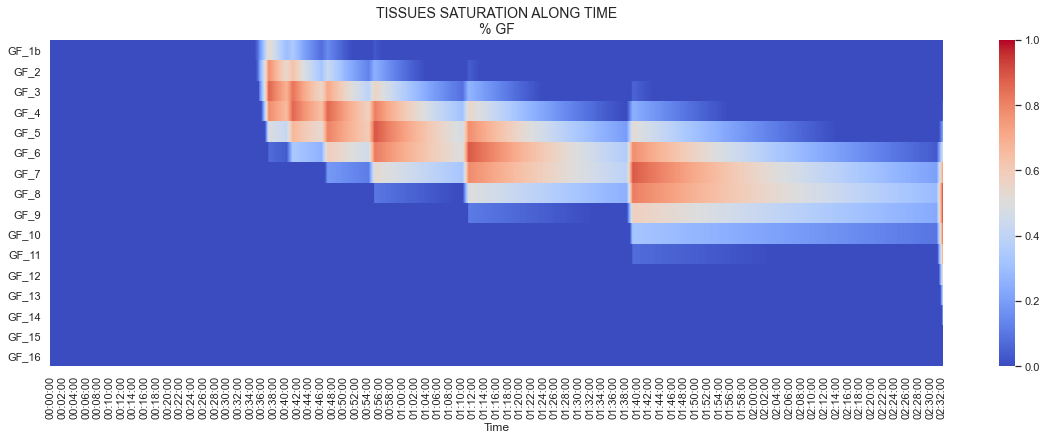

In [29]:
df_c = df2[['Time'] + [c for c in df2.columns if (c.startswith("GF_"))]]
df_c = df_c.loc[(df_c['Time'].dt.second % 10) == 0]
df_c.index = df_c['Time'].dt.time
df_c = df_c[[c for c in df_c.columns if c not in 'Time']].transpose()
fig, ax = plt.subplots(1, figsize = (20, 6))
sns.heatmap(df_c, vmin = 0, vmax = 1, cmap = "coolwarm")
plt.title('TISSUES SATURATION ALONG TIME\n% GF', fontsize = 14)
plt.show()

<ipython-input-55-7d04f4bc07f6>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, 1].set_xticklabels(df2['Time'], rotation = 30)


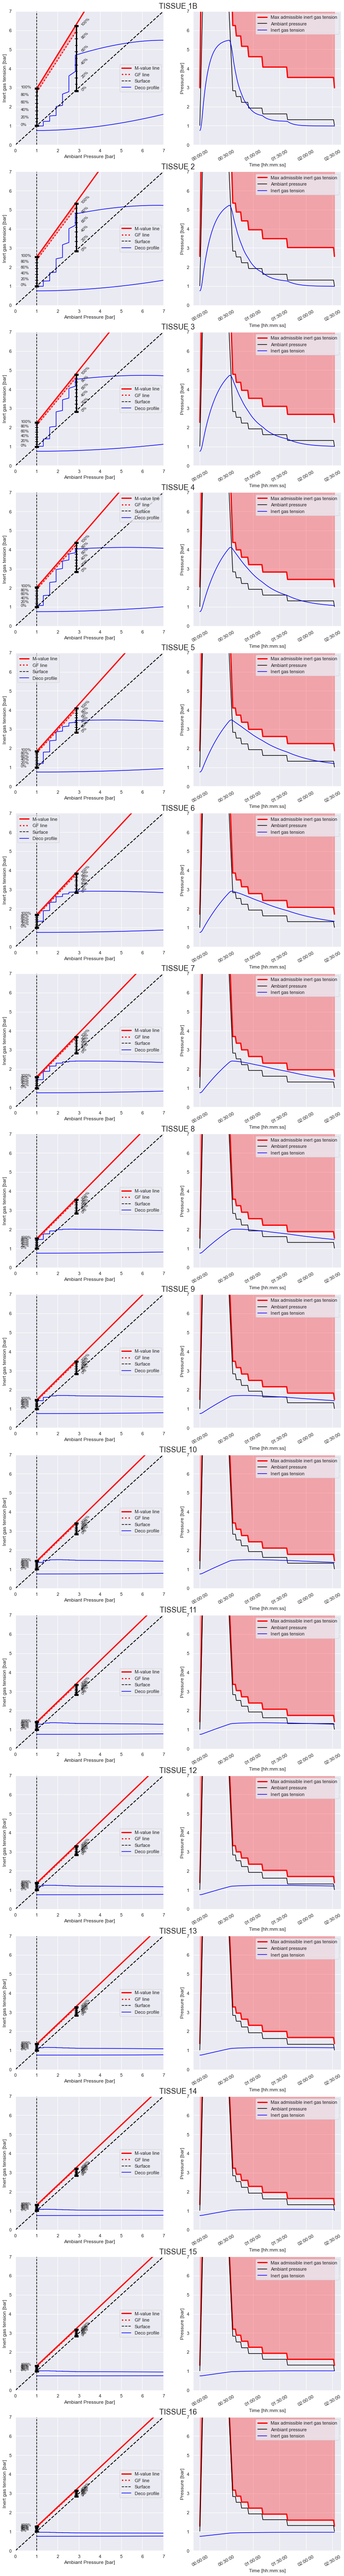

In [55]:
cells = list(M_values.keys())
fig, axs = plt.subplots(len(cells), 2, figsize = (14, 7 * len(cells)))
i = 0
for cell in cells:
    col_name = "pN2_cell_" + cell + " [bar]"
    M0 = M_values[cell]['M0']
    M_slope = M_values[cell]['M_Slope']
    Pamb_first_deco_stop = pressure_at_depth(first_deco_stop)
    x = [i for i in range(1, 8)]
    M_line = [(p - p_atm_sea_level) * M_slope + M0 for p in x]

    axs[i, 0].plot(x, M_line, color = 'red', linewidth = 3, label = "M-value line")
    
    GF_x1 = np.array([p_atm_sea_level, p_atm_sea_level + (M0 - p_atm_sea_level) * GF_high])
    GF_x2 = np.array([Pamb_first_deco_stop, (M0 + M_slope * (Pamb_first_deco_stop - p_atm_sea_level) - Pamb_first_deco_stop) * GF_low + Pamb_first_deco_stop])
    
    axs[i, 0].plot([GF_x1[0], GF_x2[0]], [GF_x1[1], GF_x2[1]], color = 'red', linestyle = 'dotted', linewidth = 3, label = "GF line")
    axs[i, 0].plot([1., 1.], [0., 7.], linestyle = '--', color = 'black', label = "Surface")
    axs[i, 0].plot(df2['Ambiant Pressure [bar]'], df2[col_name], color = 'blue', label = "Deco profile")
    axs[i, 0].set_xlabel('Ambiant Pressure [bar]')
    axs[i, 0].set_ylabel('Inert gas tension [bar]')
    axs[i, 0].set_xlim([0., 7.])
    axs[i, 0].set_ylim([0., 7.])
    axs[i, 0].plot([0., 7.], [0., 7.], color = 'black', linestyle = '--', linewidth = 2)
    axs[i, 0].set_title("TISSUE " + cell.upper(), fontsize = 18)
    axs[i, 0].fill_between([GF_x1[0], GF_x2[0]], [GF_x1[1], GF_x2[1]], [M0, M0 + M_slope * (Pamb_first_deco_stop - p_atm_sea_level)], linewidth = 2., color = 'red', alpha = 0.2)
    #axs[i, 0].fill_between(x, M_line, 7., color = 'red', alpha = 0.3)
    ttl = axs[i, 0].title
    ttl.set_position([1.1, 1.2])
    axs[i, 0].legend()
    
    x1 = np.array([Pamb_first_deco_stop, Pamb_first_deco_stop])
    M_value = M0 + M_slope * (Pamb_first_deco_stop - p_atm_sea_level)
    x2 = np.array([Pamb_first_deco_stop, M_value])
    axs[i, 0].plot([x1[0] + 0.05, x2[0] + 0.05], [x1[1], x2[1]], color = 'black', linewidth = 3, marker = '_', markersize = 10, markeredgewidth = 5)
    for k in range(0, 11, 1):
        x1_marker = x1 + (x2 - x1) * (k/10)
        if (k%2 == 0):
            axs[i, 0].scatter([x1_marker[0] + 0.05], [x1_marker[1]], marker = '_', color = 'black', s = 50)
            axs[i, 0].text(x1_marker[0] + 0.25, x1_marker[1], str(k*10) + "%", fontsize = 10, rotation = 45)
        else:
            axs[i, 0].scatter([x1_marker[0] + 0.05], [x1_marker[1]], marker = '_', color = 'black', s = 30)

    x1 = np.array([1., 1.])
    x2 = np.array([1, M0])
    axs[i, 0].plot([x1[0], x2[0]], [x1[1], x2[1]], color = 'black', linewidth = 3, marker = '_', markersize = 10, markeredgewidth = 5)
    for z in range(0, 11, 1):
        x1_marker = x1 + (x2 - x1) * (z/10)
        if (z%2 == 0):
            axs[i, 0].scatter([x1_marker[0]], [x1_marker[1]], marker = '_', color = 'black', s = 50)
            axs[i, 0].text(x1_marker[0] - 0.75, x1_marker[1], str(z*10) + "%", fontsize = 10)        
        else:
            axs[i, 0].scatter([x1_marker[0]], [x1_marker[1]], marker = '_', color = 'black', s = 30)
       
    M_val_lim = (df2['Ambiant Pressure [bar]'] - 1.) * M_slope + M0
    axs[i, 1].plot(df2['Time'], M_val_lim, color = 'red', linewidth = 3, label = "Max admissible inert gas tension")
    axs[i, 1].plot(df2['Time'], df2['Ambiant Pressure [bar]'], color = 'black', label = "Ambiant pressure")
    axs[i, 1].plot(df2['Time'], df2[col_name], color = 'blue', label = "Inert gas tension")
    axs[i, 1].set_xticklabels(df2['Time'], rotation = 30)
    axs[i, 1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    axs[i, 1].fill_between(df2['Time'], M_val_lim, 100., color = 'red', alpha = 0.3)
    axs[i, 1].set_xlabel('Time [hh:mm:ss]')
    axs[i, 1].set_ylabel('Pressure [bar]')
    axs[i, 1].set_ylim([0., 7.])
    axs[i, 1].legend()   
    i += 1

plt.savefig("deco_profile.pdf")

In [50]:
GF_x1

array([1.01325   , 1.24310764])

In [51]:
GF_x2

array([2.832024  , 3.12072377])